Mount shared folder

In [1]:
# 1. Install PyDrive2
!pip install -U PyDrive2




In [2]:
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# Create GoogleAuth and manually inject Colab's credentials
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Now you can access the shared folder by ID
FOLDER_ID = "1l5C63-tuOUo8K97lPRaNTP-T4ig788Eg"

file_list = drive.ListFile(
    {'q': f"'{FOLDER_ID}' in parents and trashed=false"}
).GetList()

for f in file_list:
    print(f['title'], ' - ', f['id'], ' - ', f['mimeType'])

SAND Tasks  -  1q-ytnNg-Jc6B4KsteRiP3MKqesEoaJa4  -  application/vnd.google-apps.folder
VOC-ASLInputAnalysis.ipynb  -  1tt02fBXuLzrWI_oXTM9fjjcrowXGnYpD  -  application/vnd.google.colaboratory
Prova.ipynb  -  1kaHZV4y1rcw4giJjdVuBN4lL-nW3Pati  -  application/vnd.google.colaboratory
VOC-ALS Database  -  1KQ1DHvSIZq3P0d-3ghg23hu18P_2rIMs  -  application/vnd.google-apps.folder
Dysarthria Datasets  -  1gfl76nrQtZcLrtd-30pHIEmhuPQPal22O5mrGBFFT44  -  application/vnd.google-apps.spreadsheet
Classifcation of Dysarthria based on the Levels of Severity. A Systematic Review.pdf  -  1im98usRvqXbTZ6t6AGHrxO4BB_l-PbFz  -  application/pdf


Load the wav data from the shared folder and save them as .npy alongside a .csv for tracking ids

Run this only the first time

In [4]:
import os
import numpy as np
import pandas as pd
import librosa

# Folder in shared drive where you want to save
# Replace with your actual folder inside the shared folder
SAVE_FOLDER_ID = "1l5C63-tuOUo8K97lPRaNTP-T4ig788Eg"  # VOC-ALS Database
SAVE_SUBFOLDER_NAME = "processed_numpy"  # new subfolder to hold npy + CSV

def list_children(parent_id):
    """List files/folders inside a given folder ID."""
    return drive.ListFile({'q': f"'{parent_id}' in parents and trashed=false"}).GetList()

def find_child_by_name(parent_id, name):
    """Find the ID of a child item by its title."""
    for item in list_children(parent_id):
        if item['title'] == name:
            return item['id'], item['mimeType']
    return None, None

# 1. Create subfolder in shared folder (if it doesn't exist)
def create_subfolder(parent_id, name):
    # Check if folder exists
    for item in list_children(parent_id):
        if item['title'] == name and item['mimeType'] == 'application/vnd.google-apps.folder':
            return item['id']
    folder = drive.CreateFile({'title': name, 'mimeType': 'application/vnd.google-apps.folder', 'parents':[{'id': parent_id}]})
    folder.Upload()
    return folder['id']

save_folder_id = create_subfolder(SAVE_FOLDER_ID, SAVE_SUBFOLDER_NAME)

# 2. Loop through all subfolders and save waveforms as .npy
records = []

vocals_id, _ = find_child_by_name(SAVE_FOLDER_ID, "VOC-ALS Database")

for subfolder in list_children(vocals_id):
    if subfolder['mimeType'] == 'application/vnd.google-apps.folder':
        subfolder_id = subfolder['id']
        for item in list_children(subfolder_id):
            if item['title'].lower().endswith(".wav"):
                file_id = item['id']
                filename = item['title'].replace(".wav", "")

                # Download temporarily
                local_path = f"/content/{item['title']}"
                wav_file = drive.CreateFile({'id': file_id})
                wav_file.GetContentFile(local_path)

                # Load audio
                y, sr = librosa.load(local_path, sr=None)

                # Save as .npy locally first
                npy_local_path = f"/content/{filename}.npy"
                np.save(npy_local_path, y)

                # Upload .npy to shared folder
                npy_drive_file = drive.CreateFile({'title': f"{filename}.npy", 'parents':[{'id': save_folder_id}]})
                npy_drive_file.SetContentFile(npy_local_path)
                npy_drive_file.Upload()

                # Record metadata
                records.append({"filename": filename, "sr": sr, "drive_file_id": npy_drive_file['id']})

# 3. Create DataFrame with metadata
df = pd.DataFrame(records)

# 4. Save DataFrame as CSV locally
csv_local_path = "/content/voc_als_index.csv"
df.to_csv(csv_local_path, index=False)

# 5. Upload CSV to shared folder
csv_drive_file = drive.CreateFile({
    'title': "voc_als_index.csv",
    'parents': [{'id': save_folder_id}],
    'mimeType': 'text/csv'   # ensures it's treated as a true CSV
})
csv_drive_file.SetContentFile(csv_local_path)
csv_drive_file.Upload()

print("✅ All .npy files and DataFrame CSV saved to shared folder.")


✅ All .npy files and DataFrame CSV saved to shared folder.


In [19]:
df.head()

,filename,sr,drive_file_id
0,PZ115_rhythmTA,8000,1sU6lD16qCHN38bXXmG5Eut6XIMl6BNxk
1,PZ114_rhythmTA,8000,1nO6IF2M-7GUT_vQXWFAFPxwgPRvuM6dW
2,PZ112_rhythmTA,8000,1eiGHxJAdoSCXl15DnrBTHUYjVlGAFXjn
3,PZ111_rhythmTA,8000,1RhHANB2o13lrijWkFKRL0m30ZPTRjwtU
4,PZ110_rhythmTA,8000,18qORWrCpaW8UfSdCAQFJLP034tWhvi2Z


Load and analyze data

In [25]:
import pandas as pd
import numpy as np
from pydrive2.drive import GoogleDrive

# Load the CSV index from Drive
# Replace this with the Drive ID of your CSV if needed
INDEX_FILE_ID = "1XqyGmoqMKamP3jf3DR-Lo8V4haX3SPNp"
local_index_path = "/content/voc_als_index.csv"

# Download the CSV index
csv_file = drive.CreateFile({'id': INDEX_FILE_ID})
csv_file.GetContentFile(local_index_path)  # no mimetype for true CSV

# Load into DataFrame
df_index = pd.read_csv(local_index_path)

# Helper function to load waveform by filename
def load_waveform(filename):
    """
    Loads a waveform from Drive using the filename (without .npy extension).
    Returns the waveform as a NumPy array.
    """
    row = df_index[df_index['filename'] == filename]
    if row.empty:
        raise ValueError(f"File '{filename}' not found in index.")

    file_id = row['drive_file_id'].values[0]

    # Download .npy temporarily
    local_path = f"/content/{filename}.npy"
    npy_file = drive.CreateFile({'id': file_id})
    npy_file.GetContentFile(local_path)

    # Load as NumPy array
    return np.load(local_path)

# Example usage:
waveform = load_waveform("CT001_phonationA")
print("Waveform shape:", waveform.shape)

Waveform shape: (113600,)


In [26]:
df_index.head()

,filename,sr,drive_file_id
0,PZ115_rhythmTA,8000,1sU6lD16qCHN38bXXmG5Eut6XIMl6BNxk
1,PZ114_rhythmTA,8000,1nO6IF2M-7GUT_vQXWFAFPxwgPRvuM6dW
2,PZ112_rhythmTA,8000,1eiGHxJAdoSCXl15DnrBTHUYjVlGAFXjn
3,PZ111_rhythmTA,8000,1RhHANB2o13lrijWkFKRL0m30ZPTRjwtU
4,PZ110_rhythmTA,8000,18qORWrCpaW8UfSdCAQFJLP034tWhvi2Z


Text(0.5, 1.0, 'phonationA')

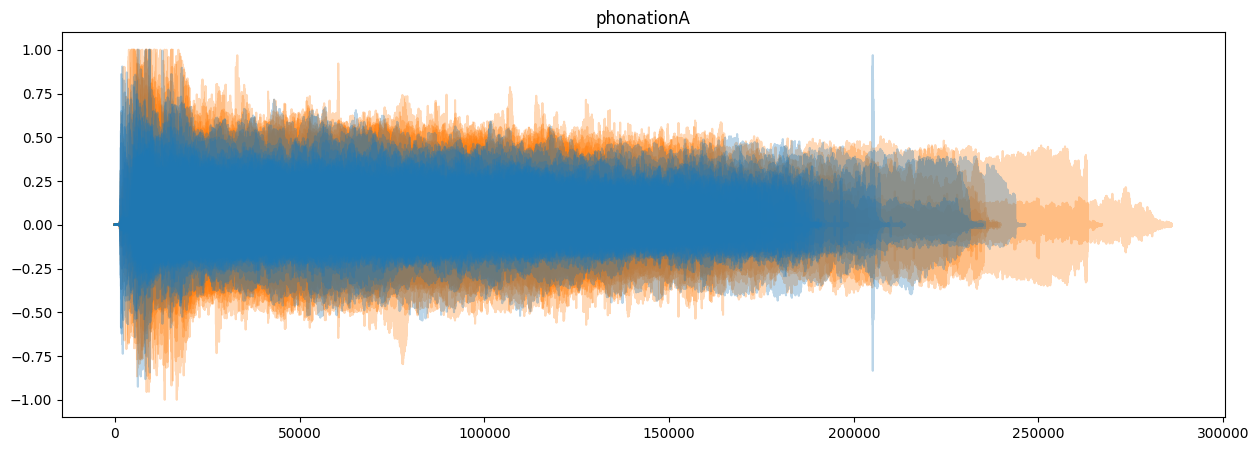

In [27]:
# print each repetition of the selected exercise overlayed and color based of the prefix CT / PZ
from matplotlib import pyplot as plt

exercise = 'phonationA'

plt.figure(figsize=(15, 5))
for index, row in df_index.iterrows():
  # print an advancing bar
  print(f"{index}/{df_index.shape[0]}", end="\r")
  if exercise in row['filename']:
        waveform = load_waveform(row['filename'])
        plt.plot(waveform, alpha = 0.3, color = 'C0' if 'CT' in row['filename'] else 'C1')
plt.title(exercise)

Fourier analysis

Text(0.5, 1.0, 'rhythmTA')

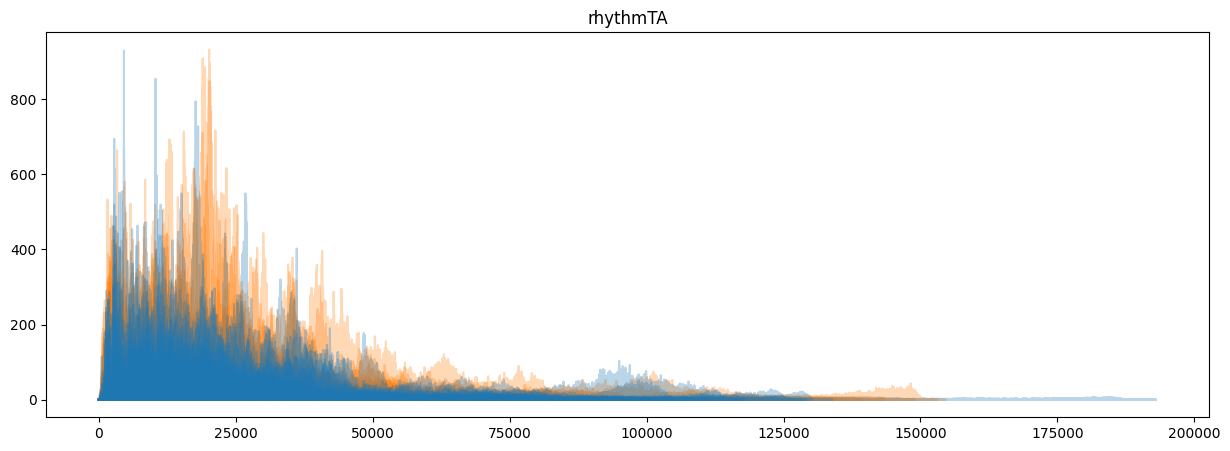

In [79]:
# Compute the fourier trasform for phonationA

from matplotlib import pyplot as plt
import numpy as np

fft_list = []
id_list = []

exercise = 'rhythmTA'

plt.figure(figsize=(15, 5))
for index, row in df_index.iterrows():
  # print an advancing bar
  print(f"{index}/{df_index.shape[0]}", end="\r")
  if exercise in row['filename']:
        waveform = load_waveform(row['filename'])
        fft = np.abs(np.fft.rfft(waveform))
        fft_list.append(fft)
        id_list.append(row['filename'])
        plt.plot(fft, alpha = 0.3, color = 'C0' if 'CT' in row['filename'] else 'C1')
plt.title(exercise)

Text(0, 0.5, 'Amplitude')

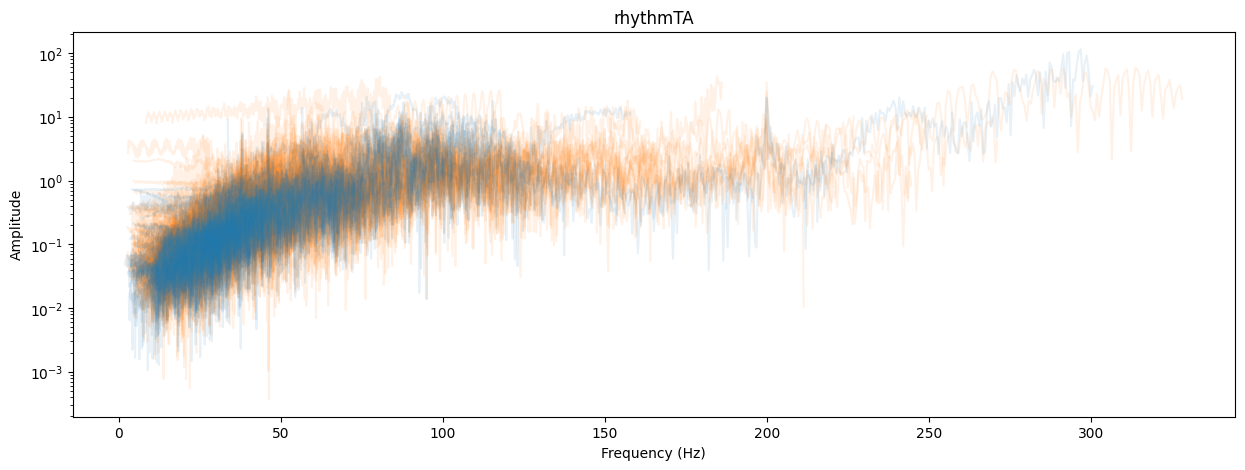

In [82]:
# lets create a freq array for each fft
fa = 8000 # Acquisition frequency
freq_list = []
for fft in fft_list:
  freq_list.append(np.fft.rfftfreq(len(fft), 1/fa))

# now let se only the first frequencies
f_min = 50
f_max = 500
plt.figure(figsize=(15, 5))
for id, fft, freq in zip(id_list, fft_list, freq_list):
  plt.semilogy(freq[f_min:f_max], fft[f_min:f_max], alpha = 0.1, color = 'C0' if 'CT' in id else 'C1')
plt.title(exercise)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

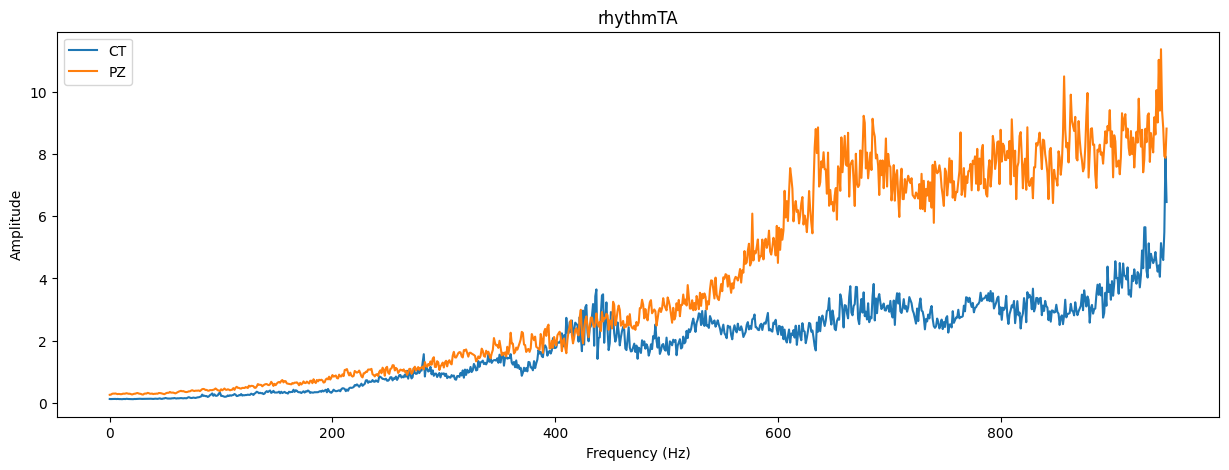

In [81]:
# average fft for all CT and for all PZ
fft_CT = []
fft_PZ = []
for id, fft, freq in zip(id_list, fft_list, freq_list):
  if 'CT' in id:
    fft_CT.append(fft)
  else:
    fft_PZ.append(fft)

# Find the maximum length among all FFTs
max_len = max(len(fft) for fft in fft_list)

# Pad FFT arrays to the maximum length
fft_CT_padded = np.array([np.pad(fft, (0, max_len - len(fft)), 'constant') for fft in fft_CT])
fft_PZ_padded = np.array([np.pad(fft, (0, max_len - len(fft)), 'constant') for fft in fft_PZ])


fft_CT = np.mean(fft_CT_padded, axis=0)
fft_PZ = np.mean(fft_PZ_padded, axis=0)

f_min = 50
f_max = 1000


plt.figure(figsize=(15, 5))
plt.plot(fft_CT[f_min:f_max], color = 'C0', label = 'CT')
plt.plot(np.arange(f_min, f_max),fft_PZ[f_min:f_max], color = 'C1', label = 'PZ')
plt.title(exercise)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()